## The Wave Equation
The wave equation is a second order hyperbolic PDE which models wave displacement $u(x,t)$ such that $$\frac{\partial^2u}{\partial t^2} = c^2\frac{\partial^2u}{\partial x^2}$$ with wave speed $c$. Typically we require two boundary and initial conditions. We solve the wave equation with the following conditions
- $u(0,t) = 0$
- $u(L,t) = 0$
- $u(x,0) = u(x)$
- $u_t(x,0) = v(x)$

We search for a trial function of the form $$U(x,t) = A(x,t) + B(x,t,N(x,t;\theta))$$ where $N$ is the neural network with parameters $\theta$ we seek to train. Here, $B = 0$ initially and on all boundaries while $A$ satisfies the boundary and initial conditions. A function of the form 

$$U(x,t) = (L-t^2)u(x) + tv(x) + x(L-x)t^2N(x,t;\theta)$$ 

It can be readily checked that $U$ satisfies all initial and boundary conditions, provided $u(0) = u(L) = v(0) = v(L) = 0$. 

If we consider the following problem 
$$\frac{\partial^2u}{\partial t^2} = c^2\frac{\partial^2u}{\partial x^2}$$
$$u(0,t) = 0$$
$$u(L=1,t) = 0$$
$$u(x,0) = \sin(\pi x)$$
$$u_t(x,0) = -\pi\sin(\pi x)$$
This problem has the analytic solution given by 
$$u(x,t) = \sin(\pi x)\cos(\pi ct) - \frac{1}{c}\sin(\pi ct)\sin(\pi x)$$

In [2]:
import autograd.numpy as np
from autograd import hessian, grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set up the trial function:
def u(x):
    return np.sin(np.pi * x)

def v(x):
    return -np.pi * np.sin(np.pi * x)#np.zeros_like(x)

def h1(point):
    x, t = point
    return (1 - t**2) * u(x) + t * v(x)

def g_trial(point, P):
    x, t = point
    return h1(point) + x * (1 - x) * t**2 * deep_neural_network(P, point)

## Define the cost function
def cost_function(P, x, t): #improve!!
    cost_sum = 0
    g_t_hessian_func = hessian(lambda pt: g_trial(pt, P))

    for x_ in x:
        for t_ in t:
            point = np.array([x_, t_])
            g_t_hessian = g_t_hessian_func(point)

            g_t_d2x = g_t_hessian[0][0]
            g_t_d2t = g_t_hessian[1][1]

            err_sqr = (g_t_d2t - g_t_d2x) ** 2
            cost_sum += err_sqr

    return cost_sum / (np.size(t) * np.size(x))

## The neural network
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    x = x.reshape(len(x), -1)  # Ensure x is a column vector
    num_points = np.size(x, 1)

    N_hidden = len(deep_params) - 1  # Hidden layers

    x_prev = x
    for l in range(N_hidden):
        w_hidden = deep_params[l]
        x_prev = np.concatenate((np.ones((1, num_points)), x_prev), axis=0)  # Add bias
        x_prev = sigmoid(np.matmul(w_hidden, x_prev))  # Activation

    # Output layer
    w_output = deep_params[-1]
    x_prev = np.concatenate((np.ones((1, num_points)), x_prev), axis=0)  # Add bias
    return np.matmul(w_output, x_prev)[0, 0]  # Ensure scalar output

## The analytical solution
def g_analytic(point):
    x, t = point
    return np.sin(np.pi * x) * np.cos(np.pi * t) - np.sin(np.pi * x) * np.sin(np.pi * t)

def solve_pde_deep_neural_network(x, t, num_neurons, num_iter, lmb):
    N_hidden = len(num_neurons)
    P = [npr.randn(num_neurons[0], 2 + 1)]  # Input layer

    for l in range(1, N_hidden):
        P.append(npr.randn(num_neurons[l], num_neurons[l - 1] + 1))

    P.append(npr.randn(1, num_neurons[-1] + 1))  # Output layer

    print('Initial cost: ', cost_function(P, x, t))

    cost_function_grad = grad(cost_function, 0)

    for i in range(num_iter):
        cost_grad = cost_function_grad(tuple(P), x, t)  # Use tuple(P) for autograd compatibility
        for l in range(N_hidden + 1):
            P[l] -= lmb * cost_grad[l]

    print('Final cost: ', cost_function(P, x, t))
    return P

In [3]:
npr.seed(15)

Nx, Nt = 25, 25
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)

num_hidden_neurons = [35,35,35]
num_iter = 100
lmb = 0.01

P = solve_pde_deep_neural_network(x, t, num_hidden_neurons, num_iter, lmb)
res = np.zeros((Nx, Nt))
res_analytical = np.zeros((Nx, Nt))

for i, x_ in enumerate(x):
    for j, t_ in enumerate(t):
        point = np.array([x_, t_])
        res[i, j] = g_trial(point, P)
        res_analytical[i, j] = g_analytic(point)

diff = np.abs(res - res_analytical)
print("Max difference:", np.max(diff))


Initial cost:  154.72815106095678
Final cost:  4.097110516797255
Max difference: 0.3606472169738367


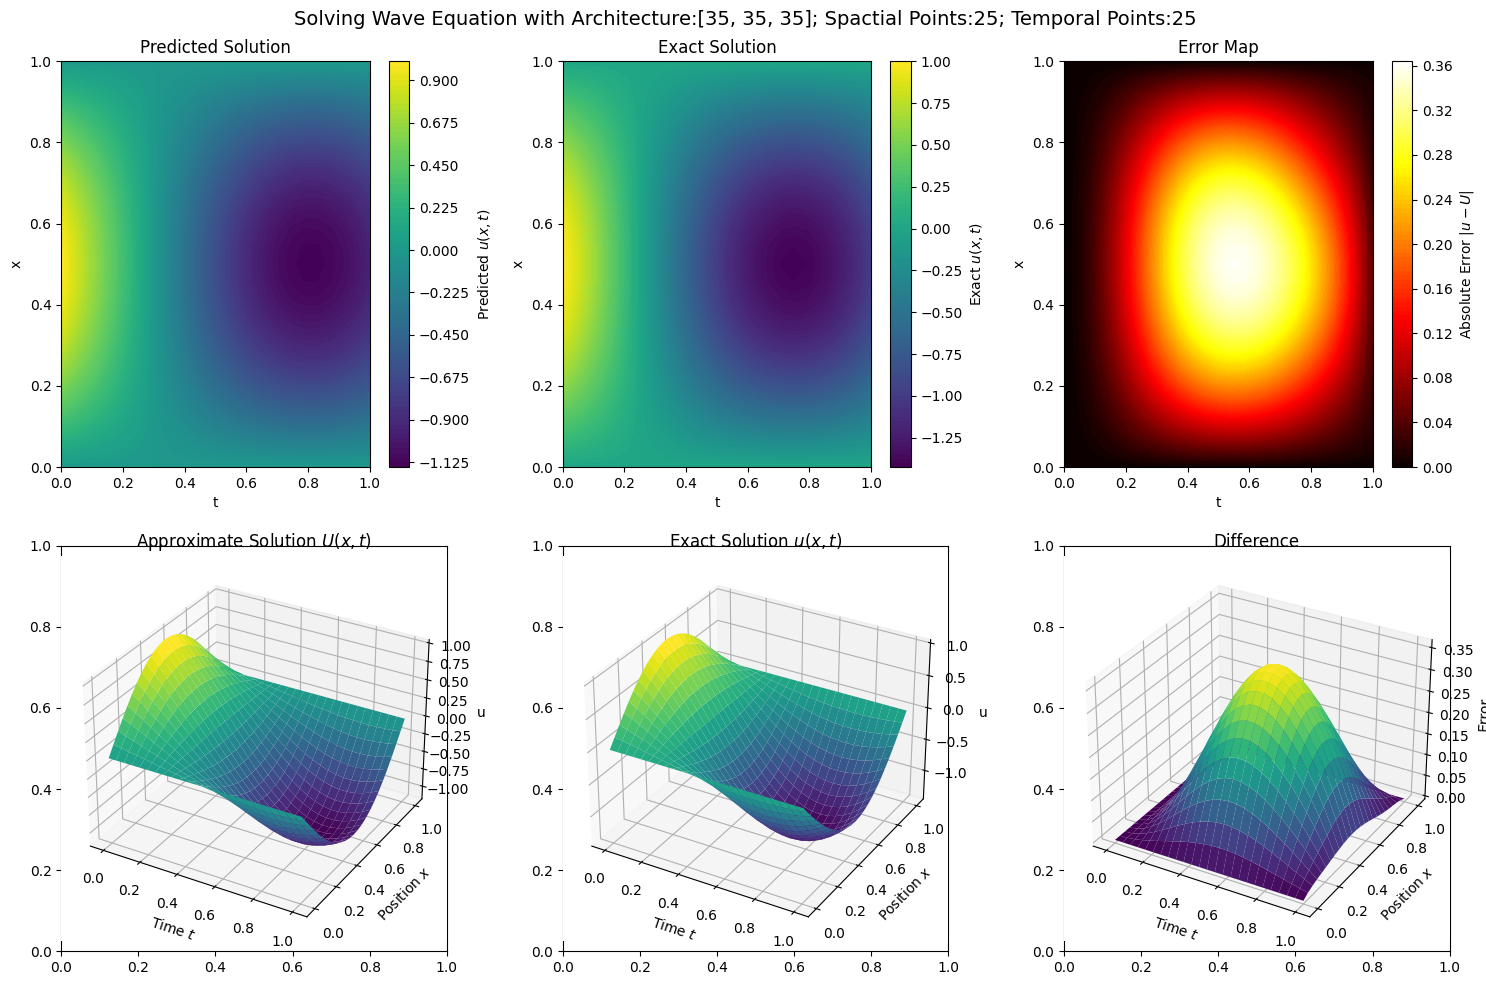

In [4]:
T, X = np.meshgrid(t, x)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Contour plots
c1 = axes[0, 0].contourf(T, X, res, levels=100, cmap="viridis")
fig.colorbar(c1, ax=axes[0, 0], label="Predicted $u(x,t)$")
axes[0, 0].set_title("Predicted Solution")
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('x')

c2 = axes[0, 1].contourf(T, X, res_analytical, levels=100, cmap="viridis")
fig.colorbar(c2, ax=axes[0, 1], label="Exact $u(x,t)$")
axes[0, 1].set_title("Exact Solution")
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('x')

c3 = axes[0, 2].contourf(T, X, diff, levels=100, cmap="hot")
fig.colorbar(c3, ax=axes[0, 2], label="Absolute Error $|u - U|$")
axes[0, 2].set_title("Error Map")
axes[0, 2].set_xlabel('t')
axes[0, 2].set_ylabel('x')

# 3D Surface plots
ax1 = fig.add_subplot(2, 3, 4, projection='3d')
ax1.plot_surface(T, X, res, cmap="viridis", edgecolor='none')
ax1.set_title("Approximate Solution $U(x,t)$")
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Position $x$')
ax1.set_zlabel("u")

ax2 = fig.add_subplot(2, 3, 5, projection='3d')
ax2.plot_surface(T, X, res_analytical, cmap="viridis", edgecolor='none')
ax2.set_title("Exact Solution $u(x,t)$")
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Position $x$')
ax2.set_zlabel("u")

ax3 = fig.add_subplot(2, 3, 6, projection='3d')
ax3.plot_surface(T, X, diff, cmap=cm.viridis, edgecolor='none')
ax3.set_title("Difference")
ax3.set_xlabel('Time $t$')
ax3.set_ylabel('Position $x$')
ax3.set_zlabel("Error")
fig.suptitle(f"Solving Wave Equation with Architecture:{num_hidden_neurons}; Spactial Points:{Nx}; Temporal Points:{Nt}", fontsize=14)
plt.tight_layout()
plt.show()